## Lettura dei file .edf e .rml

- I files edf (European data format) contengono i dati del polisonnigrafo e le registrazioni dei microfoni
- I files rml contengono le annotazioni in un formato molto simile a xml.

In [1]:
import os
# from pyedflib import highlevel
# import pyedflib as plib
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import IPython.display as ipd


### Prova di lettura di un file edf:

In [2]:
path = "/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF/00001120-100507[001].edf"
signals, signal_headers, header = highlevel.read_edf(path)

In [3]:
len(signals)

20

il file edf ha 20 segnali, contenenti ognuno i dati da un sensore differente

In [4]:
for n in range(len(signals)):
    print(signal_headers[n])

{'label': 'EEG A1-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}
{'label': 'EEG C3-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}
{'label': 'EEG C4-A1', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}
{'label': 'EOG LOC-A2', 'dimension': 'uV', 'sample_rate': 200.0, 'sample_frequency': 200.0, 'physical_max': 313.0, 'physical_min': -313.0, 'digital_max': 32767, 'digital_min': -32768, 'prefilter': 'HP:0,3Hz LP:93,6Hz N:50/60Hz', 'transducer': ''}
{'label': 'EOG 

il segnale di nostro interesse è quello del microfono tracheale.

La registrazione ha durata 60 minuti (172800000 campioni @ 48kHz)

In [22]:
signals[19].shape

(172800000,)

esempio di spettrogramma di una porzione estratta a caso:

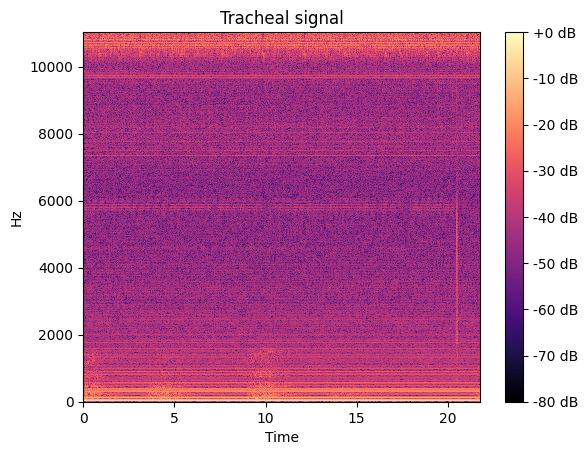

In [6]:
D = librosa.stft(signals[19][480000:2*480000])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Tracheal signal')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

### Lettura-downsample-salvataggio di tutte le registrazioni di un paziente

(estrazione della sequenza audio dall'edf e salvataggio in wav)

In [ ]:
p_ids = ["00001095", "00001097", "00001104", "00001106", "00001108", "00001110", "00001112", "00001116", "00001118", "00001120"]
data_path = "/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF"
for p_id in p_ids:
    paths = os.listdir(os.path.join(data_path, p_id))
    for p in paths:
        if p[-3:] == 'edf':
            signals, signal_headers, header = highlevel.read_edf(os.path.join(data_path, p_id, p))
            if signal_headers[19]['label'] =='Tracheal':
                print(f'resample {p} Tracheal audio data... ', end='')
                y_48k = signals[19]
                # print(f'> Signal shape: {signals[19].shape}')
                # print(f'> Data type: {type(signals[19])}')
                y_16k = librosa.resample(y_48k, orig_sr=48000, target_sr=16000)
                wf = p[:-3] + 'wav'
                sf.write(os.path.join(data_path, p_id, wf), y_16k, 16000, subtype='PCM_24')
                print('done')
    print('')

# al termine della conversione cancellare gli edf

### Prova di lettura di un file _rml_:

Estrazione della struttura contenente le annotazioni di tutti gli eventi (vedi file README.txt) in formato Pandas dataframe.

In [ ]:
df = pd.read_xml("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/00001120-100507.rml",
                 namespaces = {"ns": "http://www.respironics.com/PatientStudy.xsd"},
                 parser = "etree",
                 xpath=".//ns:Event")

df.head(50)

Posso estrarre solo gli eventi di un particolare tipo (Type) o famiglia (Family).

vedi README.txt per tutti i tipi e famiglie.

In [9]:
apnea_df = df[df["Type"] == "ObstructiveApnea"]
print(f'Found {len(apnea_df)} items')
apnea_df.head()

Found 171 items


,Family,Type,Start,Duration,Machine,OriginatedOnDevice,ChannelGain,ChannelFail,HRBefore,HRExtreme,LegMovement,O2Before,O2Min,HRIncreaseAfter
37,Respiratory,ObstructiveApnea,692.5,12.0,NaN,NaN,NaN,NaN,62.0,61.0,NaN,96.0,92.0,1.0
52,Respiratory,ObstructiveApnea,858.0,13.5,NaN,NaN,NaN,NaN,61.0,61.0,NaN,96.0,93.0,4.0
56,Respiratory,ObstructiveApnea,972.0,12.5,NaN,NaN,NaN,NaN,64.0,61.0,NaN,96.0,94.0,2.0
59,Respiratory,ObstructiveApnea,1034.0,16.0,NaN,NaN,NaN,NaN,62.0,60.0,NaN,98.0,94.0,4.0
61,Respiratory,ObstructiveApnea,1070.5,17.0,NaN,NaN,NaN,NaN,62.0,60.0,NaN,98.0,94.0,5.0


Comunque mi conviene salvare tutto il dataframe. Eventualmente lo filtro in fase di utilizzo

In [18]:
df.to_csv('out.csv', index=False)  

In [20]:
pd_reloaded = pd.read_csv('out.csv')

### Lettura di tutti i files _rml_, compilazione di un unico dataframe e salvataggio in formato _.csv_, per un utilizzo più agevole. 

In [2]:
rml_file_list = os.listdir("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/RML_clean/")
print(f'Found {len(rml_file_list)} rml files')

Found 194 rml files


In [ ]:
df = pd.DataFrame()
for n, r in enumerate(rml_file_list):
    p_id = r.split('-')[0] # extract patient id from file name
    buf_df = pd.read_xml(os.path.join("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/RML_clean", r),
                 namespaces = {"ns": "http://www.respironics.com/PatientStudy.xsd"},
                 parser = "etree",
                 xpath=".//ns:Event")
    # inserimento della colonna Patient_ID
    buf_df.insert(0, "Patient_ID", [p_id]*len(buf_df), True)
    print(f'{n} - Patient {p_id} - records {len(buf_df)}')
    df = pd.concat([df, buf_df], ignore_index=True)

In [4]:
len(df)

236534

In [5]:
df.to_csv('meta.csv', index=False)  

### Lettura di tutti i files _rml_ e plot di alcune distribuzioni

- ossimetria minima (O2Min) durante uno specifico evento apnoico
- durata degli eventi apnoici divisi per tipo

In [2]:
rml_file_list = os.listdir("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/RML_clean/")
print(f'Found {len(rml_file_list)} rml files')

Found 194 rml files


In [3]:
# Conteggio eventi per tipo
df = pd.read_csv('meta.csv', low_memory=False)
for types in df["Type"].unique():
    print(f'{types}: {len(df[df["Type"] == types])}')

Gain: 6024
ChannelFail: 24140
CentralApnea: 1718
RelativeDesaturation: 33153
Arousal: 50932
MixedApnea: 5424
ObstructiveApnea: 26184
Hypopnea: 10390
Snore: 21113
Bradycardia: 7695
Tachycardia: 3237
LongRR: 23024
PttDrop: 9892
LegMovement: 13601
HeartRateDrop: 1
PeriodicRespiration: 6


In [4]:
# Filter the dataframe for the specified event types
event_types = ['CentralApnea', 'MixedApnea', 'ObstructiveApnea', 'Hypopnea']
filtered_df = df[df['Type'].isin(event_types)]

# Calculate the total number of events for each type
event_counts = filtered_df['Type'].value_counts()

# Calculate the total duration of all events
total_duration = filtered_df['Duration'].sum()

# Calculate the total number of events
total_events = event_counts.sum()

print("Event counts:")
print(event_counts)
print("\nTotal duration of all events (in seconds):")
print(total_duration)
print("\nTotal number of events:")
print(total_events)

Event counts:
Type
ObstructiveApnea    26184
Hypopnea            10390
MixedApnea           5424
CentralApnea         1718
Name: count, dtype: int64

Total duration of all events (in seconds):
813409.5

Total number of events:
43716


In [4]:
O2Min_values = {'Obstructive': [],
                'Hypopnea': []}
Duration_values = {'Obstructive': [],
                   'Hypopnea': []}

for r in rml_file_list:
    df = pd.read_xml(os.path.join("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/RML_clean", r),
                 namespaces = {"ns": "http://www.respironics.com/PatientStudy.xsd"},
                 parser = "etree",
                 xpath=".//ns:Event")
    obstructive_apnea_df = df[df["Type"] == "ObstructiveApnea"]
    O2Min_values['Obstructive'].extend(obstructive_apnea_df.loc[:]['O2Min'].to_list())
    Duration_values['Obstructive'].extend(obstructive_apnea_df.loc[:]['Duration'].to_list())
    hypo_apnea_df = df[df["Type"] == "Hypopnea"]
    O2Min_values['Hypopnea'].extend(hypo_apnea_df.loc[:]['O2Min'].to_list())
    Duration_values['Hypopnea'].extend(hypo_apnea_df.loc[:]['Duration'].to_list())

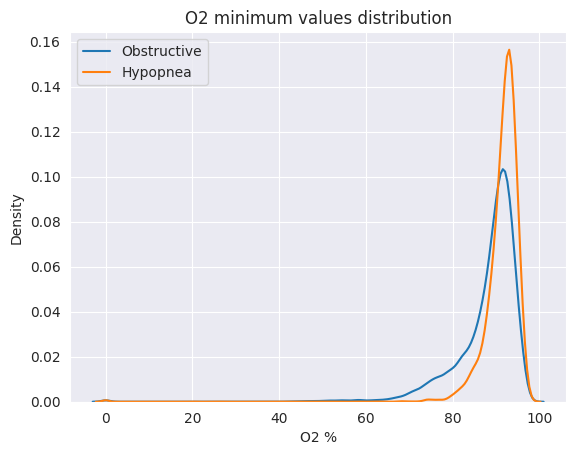

In [9]:
sns.set_style('darkgrid')
sns.kdeplot(O2Min_values['Obstructive'], cumulative=False, label='Obstructive')
sns.kdeplot(O2Min_values['Hypopnea'], cumulative=False, label='Hypopnea')
plt.xlabel('O2 %')
plt.title('O2 minimum values distribution')
plt.legend()
plt.show()

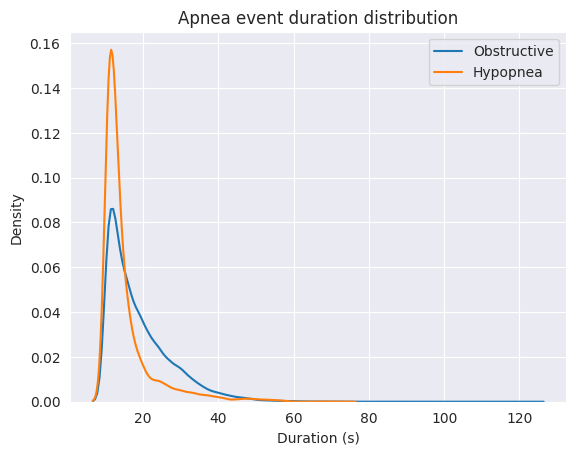

In [10]:
sns.set_style('darkgrid')
sns.kdeplot(Duration_values['Obstructive'], cumulative=False, label='Obstructive')
sns.kdeplot(Duration_values['Hypopnea'], cumulative=False, label='Hypopnea')
plt.xlabel('Duration (s)')
plt.title('Apnea event duration distribution')
plt.legend()
plt.show()

### Automatizzazione del download dei files _edf_

Per scaricare i files edf l'unico modo è 
- prendere i link da GET ALL URLs
- selezionare i link che puntano a files edf
- per ognuno di questi comporre il comando _wget -O 00000999-100507[001].edf "https://download.scidb.cn/download?fileId=61a0ca3f89f14b48842cf1ea&dataSetType=personal&fileName=00000999-100507%5B001%5D.edf"_
ed eseguirlo su linea di comando.

Alla fine raccogliere i 4 o 5 files scaricati per lo stesso paziente e metterli in una cartella con il nome del patient_id, quindi eseguire il codice nel blocco precedende (sez Lettura-downsample-salvataggio...).

Verranno creati altrettanti files wav relativi alle registrazioni tracheali, ricampionate a 16kHz (quindi meno pesanti degli edf).

Alla fine della conversione cancellare gli edf

Prima di tutto ciò controllare che tutti gli URL sono congruenti con gli ID dei files rml (stessi patient_id, né più né meno).

Secondo i miei calcoli, se una sequenza @48kHz pesa 677Mb e ricampionata @16kHz pesa 167Mb, il dataset nuovo deve pesare il 24% del dataset originale. Quindi se l'originale è 918Gb, quello ricampionato è circa 220Gb

__Formattazione file URLs__

In [15]:
with open("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF_URLs.txt", 'r') as urlfile:
    urls = urlfile.read().splitlines()

In [13]:
wget_urls = []

In [14]:
for U in urls:
    tail = U.split('=')[-1]
    tail = tail.replace('%5B', '[')
    tail = tail.replace('%5D', ']')
    wstring = "wget -O " + tail + " \"" + U +"\""
    wget_urls.append(wstring)

In [16]:
with open("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF_WGET_URLs.txt", 'w') as w:
    w.write('\n'.join(wget_urls))

### Metadati WAV

Analizzo tutti i pazienti di cui ho gli WAV e creo un dataframe con la durata delle registrazioni (in secondi)

In [2]:
data_path = "/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF"
uid_list = [d for d in os.listdir(data_path) if d[0:4]=='0000']
print(f'Found {len(uid_list)} user folders')

Found 40 user folders


In [3]:
df = pd.DataFrame(columns=["Patient ID", "WAV files", "Tot recordings"])
for uid in uid_list:
    data_path = os.path.join("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF", uid)
    w_list = [f for f in os.listdir(data_path) if f[-3:]=='wav']
    s_len = 0.0
    for wf in w_list:
        # get wav file duration without opening
        d = librosa.get_duration(path = os.path.join("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF", uid, wf))
        s_len += d
    new_entry = {"Patient ID": uid, "WAV files": len(w_list), "Tot recordings": s_len}
    df.loc[len(df)] = new_entry
df.head(50)

,Patient ID,WAV files,Tot recordings
0,00001024,5,16276.0
1,00001022,5,16843.0
2,00000995,5,17891.0
3,00001082,5,14581.0
4,00001071,5,15097.0
5,00001084,7,21703.0
6,00001018,5,15269.0
7,00001108,5,16407.0
8,00001097,6,19239.0
9,00001037,4,11867.0


### Estrazione e plot di una porzione di spettrogramma con apnea + ascolto

In [4]:
P_n = 1016
E_type = "ObstructiveApnea"
m_df = pd.read_csv('meta.csv', low_memory=False)
o_df = m_df.loc[(m_df['Type']==E_type) & (m_df["Patient_ID"]==P_n)]
o_df.head(20)

,Patient_ID,Family,Type,Start,Duration,Machine,OriginatedOnDevice,ChannelGain,ChannelFail,HRBefore,HRExtreme,O2Before,O2Min,HRIncreaseAfter,PttDrop,LegMovement,Validation,HasSigh
226643,1016,Respiratory,ObstructiveApnea,3043.0,16.0,NaN,NaN,NaN,NaN,58.0,55.0,95.0,91.0,3.0,NaN,NaN,NaN,NaN
226655,1016,Respiratory,ObstructiveApnea,3149.5,13.0,NaN,NaN,NaN,NaN,58.0,54.0,96.0,93.0,5.0,NaN,NaN,NaN,NaN
226672,1016,Respiratory,ObstructiveApnea,3443.5,15.0,NaN,NaN,NaN,NaN,59.0,55.0,95.0,86.0,5.0,NaN,NaN,NaN,NaN
226690,1016,Respiratory,ObstructiveApnea,3987.5,11.5,NaN,NaN,NaN,NaN,56.0,53.0,95.0,90.0,4.0,NaN,NaN,NaN,NaN
226735,1016,Respiratory,ObstructiveApnea,6132.0,13.0,NaN,NaN,NaN,NaN,60.0,56.0,94.0,90.0,3.0,NaN,NaN,NaN,NaN
226812,1016,Respiratory,ObstructiveApnea,9110.5,13.0,NaN,NaN,NaN,NaN,58.0,55.0,95.0,95.0,0.0,NaN,NaN,NaN,NaN
226860,1016,Respiratory,ObstructiveApnea,10780.0,12.0,NaN,NaN,NaN,NaN,55.0,55.0,96.0,85.0,1.0,NaN,NaN,NaN,NaN
226865,1016,Respiratory,ObstructiveApnea,10832.0,11.0,NaN,NaN,NaN,NaN,58.0,57.0,95.0,83.0,1.0,NaN,NaN,NaN,NaN
226870,1016,Respiratory,ObstructiveApnea,10903.0,15.5,NaN,NaN,NaN,NaN,56.0,54.0,99.0,79.0,4.0,NaN,NaN,NaN,NaN
226881,1016,Respiratory,ObstructiveApnea,11056.5,12.5,NaN,NaN,NaN,NaN,54.0,53.0,98.0,85.0,1.0,NaN,NaN,NaN,NaN


In [7]:
n = 10 # seleziono il primo evento del paziente P_n

t_start = o_df.iloc[n]['Start']
t_end = t_start + o_df.iloc[n]['Duration']
file_start = int(t_start//3600)
file_end = int(t_end//3600)

P_n = str(P_n)
f_name = P_n + "-100507[00" + str(file_start+1) + "].wav"

print(f'open {f_name}..')
# print(os.path.join("/mnt/sda1/home/caironi/DATA/PSG-Audio/v_3/EDF", P_n, f_name))
y, sr = librosa.load(os.path.join("/disks/disk1/dlillini/PSG_Audio/EDF/", P_n, f_name), sr=16000)
print(f'sample rate: {sr}')

# extract event
print(f'extract event starting at {t_start} and ending at {t_end}')
t_start-=(file_start*3600)
t_end-=(file_start*3600)
print(f'extract event starting at {t_start} and ending at {t_end}')
s_start = int(t_start*16000) - (10*16000)
s_end = int(t_end*16000)  + (10*16000)
print(f'extract event starting at sample {s_start} and ending at sample {s_end}')
y_chunk = y[s_start:s_end]


open 000000001016-100507[004].wav..


/tmp/ipykernel_9241/3372539388.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(os.path.join("/disks/disk1/dlillini/PSG_Audio/EDF/", P_n, f_name), sr=16000)


FileNotFoundError: [Errno 2] No such file or directory: '/disks/disk1/dlillini/PSG_Audio/EDF/000000001016/000000001016-100507[004].wav'

(513, 4313) complex64


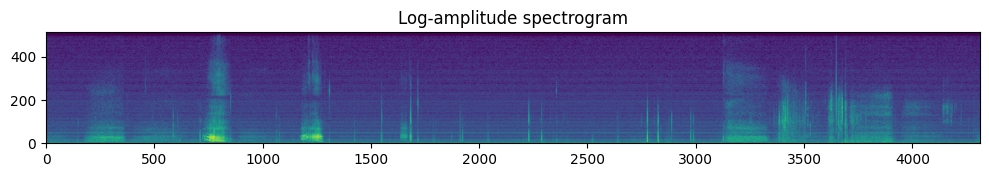

In [20]:
S1 = librosa.stft(y_chunk, n_fft=1024, win_length=1024, hop_length=128, center=True)
print(S1.shape, S1.dtype)
S1_mag, S1_pha = librosa.magphase(S1)
S1_mag_db = librosa.amplitude_to_db(S1_mag, ref=np.max) # linear to db
plt.figure(figsize=(10,10))
plt.imshow(S1_mag_db, origin='lower')
plt.title('Log-amplitude spectrogram')
plt.tight_layout()
plt.show()

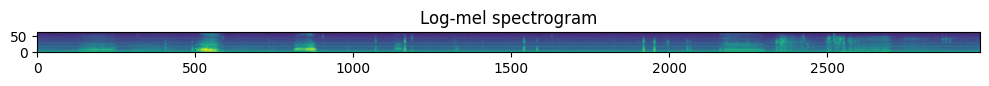

In [23]:
S2 = librosa.feature.melspectrogram(y=y_chunk, sr=sr, hop_length=185, n_mels=64)
S2_dB = librosa.power_to_db(S2, ref=np.max)
plt.figure(figsize=(10,10))
plt.imshow(S2_dB, origin='lower')
plt.title('Log-mel spectrogram')
plt.tight_layout()
plt.show()

In [22]:
ipd.Audio(y_chunk, rate=sr)